# 🔊 Proyecto clasificación de audios

Fernando Moreno

Noviembre 2022

## **Conjunto de datos**

* El conjunto de datos consiste de 30000 muestas de audio de dígitos hablados (0-9) de 60 sujetos en 500 archivos por cada uno.

* Los meta datos del conjunto de datos incluyen edades (rango: 22-61 años), sexo (12 mujeres/ 48 hombres), origen y acento de todos los hablantes.


In [1]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#6166B3', '#e8eff6', '#0b2553']

prompt = color_map[-1]
main_color = color_map[0]

css_file = '''

    div #notebook {
    background-color: white;
    line-height: 20px;
    }

    #notebook-container {
    %s
    margin-top: 2em;
    padding-top: 2em;
    border-top: 4px solid %s; /* light orange */
    -webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    }

    div .input {
    margin-bottom: 1em;
    }

    .rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
    color: %s; /* light orange */
    font-weight: 600;
    }

    div.input_area {
    border: none;
        background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
        border-top: 2px solid %s; /* light orange */
    }

    div.input_prompt {
    color: %s; /* light blue */
    }

    div.output_prompt {
    color: %s; /* strong orange */
    }

    div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
    background: %s; /* light orange */
    }

    div.cell.selected, div.cell.selected.jupyter-soft-selected {
        border-color: %s; /* light orange */
    }

    .edit_mode div.cell.selected:before {
    background: %s; /* light orange */
    }

    .edit_mode div.cell.selected {
    border-color: %s; /* light orange */

    }
    '''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

/tmp/ipykernel_175426/111401022.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


In [2]:
# For audio preprocessing
import glob
import librosa
import librosa.display as dsp
import scipy.io.wavfile as wavf
import scipy.signal
from IPython.display import Audio

# For data preprocessing
import pyarrow as pa
import datasets
import numpy as np
import os
import pandas as pd
#from datasets import Dataset
from datasets.dataset_dict import DatasetDict

# For data viz
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# For transfer learning, ResNet34
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet34
#from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader

if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')

# For Wav2Vec 2.0 (base) model, built on the Hugging Face Transformers
import random
import logging 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import AutoFeatureExtractor

# Only log error messages
tf.get_logger().setLevel(logging.ERROR)
tf.keras.utils.set_random_seed(42)

import warnings
warnings.filterwarnings("ignore")

/home/fm/anaconda3/envs/TCI_FM/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-28 10:31:13.498611: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 10:31:13.616646: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-28 10:31:14.039841: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared objec

In [3]:
# muestras de cada dígito
subject_ids = [np.random.randint(1,60) for i in range(10)]
for i in range(10): 
    if subject_ids[i]<10:
        subject_ids[i] = "0"+str(subject_ids[i])
    else:
        subject_ids[i] = str(subject_ids[i])
        
labels = [str(j) for j in range(10)]
record_ids = [str(np.random.randint(1,50)) for k in range(10)]
infos = [(labels[i], subject_ids[i], record_ids[i]) for i in range(10)]

## Reproducción de un audio en una celda del cuaderno

In [4]:
i = np.random.randint(1,10)
filepath = f"audio-mnist/data/{subject_ids[i]}/{labels[i]}_{subject_ids[i]}_{record_ids[i]}.wav"
Audio(data=filepath)

## **Visualización de los datos de audio**

El audio se refiere más comúnmente al sonido, ya que se transmite en forma de señal, consiste en ondas producidas por la oscilación de la presión del aire. Algunas características importantes como amplitud, periodo, frecuencia, entre otras permiten la respresentación gráfica del audio. En el contexto de aprendizaje profundo el enfoque comúnmente utilizado para clasificación de audios consiste en convertir los audios a imágenes y luego usar una arquitectura CNN estándar para procesar esas imágenes, frecuentemente la forma de representar los datos es un espectrograma, sin embargo también es posible usar la forma de la ondas. 

In [5]:
def get_melspectrogram_db(file_path, sr=None, n_fft=2048, hop_length=512, n_mels=128, fmin=20, fmax=8300, top_db=80):
    #sr= rata de muestreo
    #n_fft= número de muestras para cada ventana
    #hop_length= número de muestras que se salta para la siguiente ventana de tiempo
    #n_mel= número de filtros de mel, o la altura de la imagen del espectrograma
  wav, sr = librosa.load(file_path,sr=sr)
  if wav.shape[0]<1*sr:
    wav=np.pad(wav,int(np.ceil((1*sr-wav.shape[0])/2)),mode='reflect')
  else:
    wav=wav[:5*sr]
  spec=librosa.feature.melspectrogram(wav, sr=sr, n_fft=n_fft,
              hop_length=hop_length,n_mels=n_mels,fmin=fmin,fmax=fmax)
  spec_db=librosa.power_to_db(spec,top_db=top_db)
  return spec_db

In [6]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [7]:
def plot_sounds_and_specgrams(infos):
    """
    infos: list with values (label, subject, trial)
    """
    fig = plt.figure(figsize=(15, 30))
    subfigs = fig.subfigures(nrows=len(infos), ncols=1)
    
    for row, (subfig, info) in enumerate(zip(subfigs, infos)):
        (label, subject, trial) = info
        subfig.suptitle(f'Dígito {label}, Sujeto {subject}, Intento {trial}')
        
        axs = subfig.subplots(nrows=1, ncols=2)
        # set path for the audio file
        filepath = f"audio-mnist/data/{subject}/{label}_{subject}_{trial}.wav"
        dig, vp, rep = filepath.rstrip(".wav").split("/")[-1].split("_")
        #read audio file
        fs, data = wavf.read(filepath)
        #recordings were downsampled to 8kHz and zero-padded to get an 8000-dimensional vector per recording.
        data = librosa.core.resample(y=data.astype(np.float32), orig_sr=fs, target_sr=8000, res_type="scipy")
        if len(data) > 8000:
            raise ValueError("data length cannot exceed padding length.")
        elif len(data) < 8000:
            embedded_data = np.zeros(8000)
            offset = np.random.randint(low = 0, high = 8000 - len(data))
            embedded_data[offset:offset+len(data)] = data
        elif len(data) == 8000:
            embedded_data = data
            pass
    
        # Waveform graph
        librosa.display.waveshow(y=embedded_data, sr = len(embedded_data), ax=axs[0])
        axs[0].set_title('Waveform')
        axs[0].set_ylabel('Amplitude')

        # Spectrogram graph
        gms = get_melspectrogram_db(file_path=filepath)
        fig = librosa.display.specshow(spec_to_image(gms),x_axis='time',y_axis='mel', ax=axs[1])
        # Add colorbar in scale dB
        plt.colorbar(fig,format ='%+2.0f dB')
        axs[1].set_title('Spectrogram')

        for ax in axs.flat:
            ax.set(xlabel='Time (s)')

In [8]:
i = np.random.randint(1,10)
wav, sr = librosa.load(f"audio-mnist/data/{subject_ids[i]}/{labels[i]}_{subject_ids[i]}_{record_ids[i]}.wav", sr=None)
print(f'La rata de muestreo es {sr} y la longitud del audio es de {len(wav)/sr} segundos')

La rata de muestreo es 48000 y la longitud del audio es de 0.7605625 segundos


In [9]:
i = np.random.randint(1,10)
#wav, sr = librosa.load(f"audio-mnist/data/{subject_ids[i]}/{labels[i]}_{subject_ids[i]}_{record_ids[i]}.wav", sr=None)
#fs, data = wavf.read(filepath)
wav, sr = librosa.load(f"audio-mnist/data/{subject_ids[i]}/{labels[i]}_{subject_ids[i]}_{record_ids[i]}.wav", sr=None)
wav = librosa.core.resample(y=wav.astype(np.float32), orig_sr=sr, target_sr=8000, res_type="scipy")
if len(wav) > 8000:
    raise ValueError("data length cannot exceed padding length.")
elif len(wav) < 8000:
    embedded_data = np.zeros(8000)
    offset = np.random.randint(low = 0, high = 8000 - len(wav))
    embedded_data[offset:offset+len(wav)] = wav
elif len(data) == 8000:
    embedded_data = wav
    pass

print(f'La rata de muestreo es {len(embedded_data)} y la longitud del audio es de {len(embedded_data)/len(embedded_data)} segundos')

La rata de muestreo es 8000 y la longitud del audio es de 1.0 segundos


## Gráfico 1: `forma de la onda`  vs `espectrograma`

Se muestra la forma de la onda (*waveform*) y el espectrograma (*spectrogram*) de cada uno de los dígitos del 0 al 9.

+ **¿Qúe es un espectrograma?**

    Un espectrograma es una forma visual de representar la intensidad de la señal a lo largo del tiempo en varias frecuencias presentes en una forma de onda particular. Debido a que los humanos percibimos el sonido de forma no lineal es necesario hacer una transformación no lineal de los datos denominada escala Mel (percepción equidistante de la frecuencia en Hz) lo cual genera los siguientes cambios en los gráficos:
       
    + En el eje $y$ se usa la escala de Mel en lugar de la frecuencia
        
    + En la barra de color se usa la escala en decibeles en lugar de amplitud

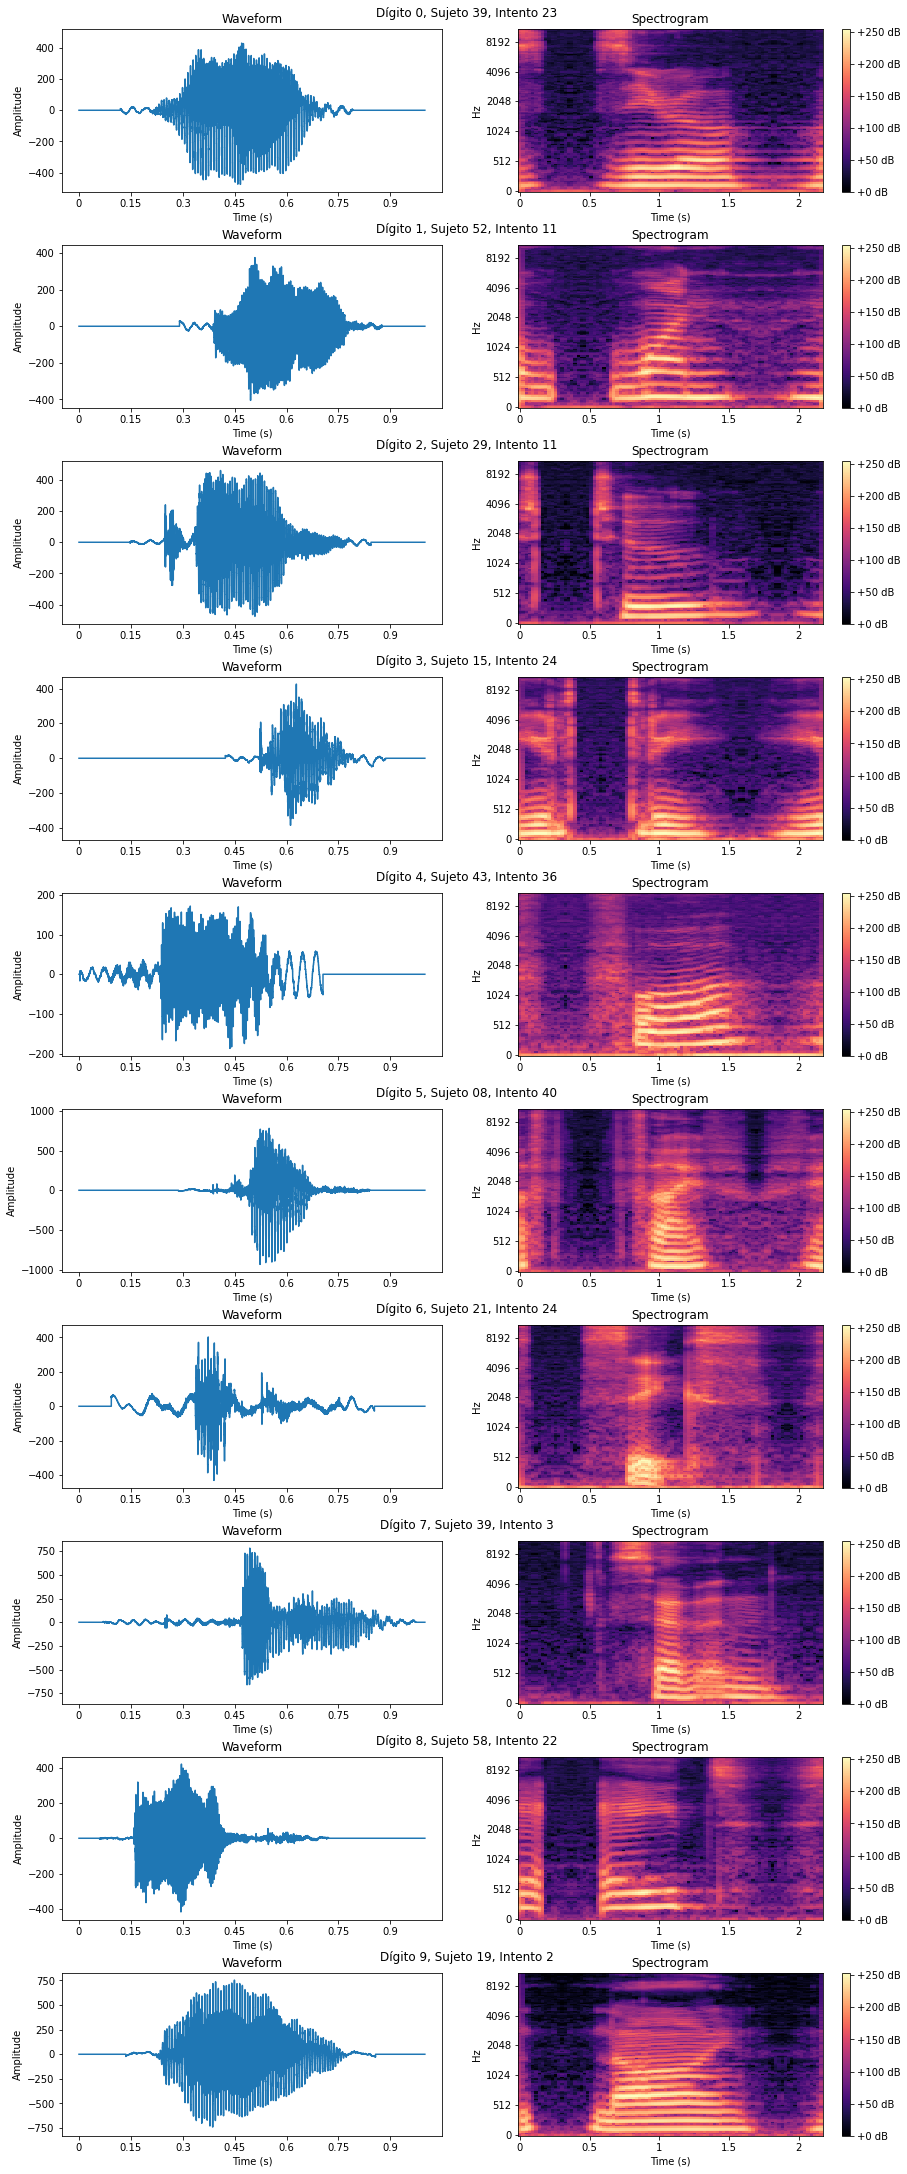

In [10]:
warnings.filterwarnings("ignore")
plot_sounds_and_specgrams(infos)

## Preprocesamiento de los datos

Se divide el conjunto de datos por sujeto en cinco partes disyuntas, cada una con 12 sujetos. En una validación cruzada 5-fold, tres de las partes se fusionan en un conjunto de entrenamiento (36 sujetos), mientras que las otras dos divisiones son respectivamente el conjunto de validación y prueba.

In [11]:
files = [x for x in sorted(glob.glob(os.path.join('audio-mnist/data', "**"), recursive = True)) if x.endswith('.wav')]

splits={"digit":{"train":[set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53, 36, 57,  9, 24, 37,  2,
                               8, 17, 29, 39, 48, 54, 43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55]),
                          set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54, 43, 58, 14, 25, 38,  3, 
                               10, 20, 30, 40, 49, 55, 12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50]),
                          set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55, 12, 47, 59, 15, 27, 41, 
                               4, 11, 21, 31, 44, 50, 26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                          set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50, 26, 52, 60, 18, 32, 42, 
                               5, 13, 22, 33, 45, 51, 28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                          set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51, 28, 56,  7, 19, 35,  1, 
                               6, 16, 23, 34, 46, 53, 36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54])],
                 
                 "validate":[set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50]),
                             set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                             set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                             set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54]),
                             set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55])],
                 
                 "test":[set([26, 52, 60, 18, 32, 42,  5, 13, 22, 33, 45, 51]),
                         set([28, 56,  7, 19, 35,  1,  6, 16, 23, 34, 46, 53]),
                         set([36, 57,  9, 24, 37,  2,  8, 17, 29, 39, 48, 54]),
                         set([43, 58, 14, 25, 38,  3, 10, 20, 30, 40, 49, 55]),
                         set([12, 47, 59, 15, 27, 41,  4, 11, 21, 31, 44, 50])]}}

files_ = {'train':{'cv1':[], 'cv2':[], 'cv3':[], 'cv4':[], 'cv5':[]},
          'validate':{'cv1':[], 'cv2':[], 'cv3':[], 'cv4':[], 'cv5':[]},
          'test':{'cv1':[], 'cv2':[], 'cv3':[], 'cv4':[], 'cv5':[]}}

for i in files_.keys():
    """
    i in ['train', 'validate', 'test']
        k in ['cv1', 'cv2', 'cv3', 'cv4', 'cv5']
            j in [if i == 'train': [0,..., 35] else: [0,...,9]]
    """
    m = 0
    for k in files_[i].keys():
        for j in range(len(splits['digit'][i][m])):
            if list(splits['digit'][i][m])[j]<10:
                a = 'audio-mnist/data/0' + str(list(splits['digit'][i][m])[j])
            else:
                a = 'audio-mnist/data/' + str(list(splits['digit'][i][m])[j])  
            files_[i][k].append([y for y in files if y.startswith(a)]) 
        m += 1

In [12]:
df_ = {'train': pd.DataFrame(), 'validate': pd.DataFrame(), 'test': pd.DataFrame()}
for k in df_.keys():
    for j in range(len(files_[k]['cv1'])):
        df = pd.DataFrame({'file':files_[k]['cv1'][j]})
        #df['audio'] = [librosa.load(df['file'][i], sr=16000) for i in range(len(df['file']))]
        df['label'] = [df['file'][i].rstrip(".wav").split("/")[-1].split("_")[0] for i in range(len(df['file']))]
        df_[k] = df_[k].append(df) 

In [13]:
[df_[i].shape for i in df_.keys()]

[(18000, 2), (6000, 2), (6000, 2)]

In [14]:
class AudioMNISTData(Dataset):
  def __init__(self, base, df, in_col, out_col):
    self.df = df #base de datos con información
    self.data = [] #las imagenes nuevas que vamos a generar
    self.labels = [] #las categorías de las respectivas imagenes
    self.c2i={} #diccionario de característica a índice
    self.i2c={} #diccionario de índice a característica
    self.categories = sorted(df[out_col].unique()) #valores únicos de las categorías, deben ser 10
    for i, label in enumerate(self.categories): #agregamos los valores a los diccionarios
      self.c2i[label]=i
      self.i2c[i]=label
    for ind in tqdm(range(len(df))): #otra forma de enumerate pero agregando barras de progreso al loop
      row = df.iloc[ind] #iteramos sobre cada fila
      file_path = os.path.join(base,row[in_col]) #buscamos el nombre del archivo y obtenemos la dirección
      self.data.append(spec_to_image(get_melspectrogram_db(file_path))[np.newaxis,...]) #esto es lo mismo que escribir  [np.newaxis,:, :, :]
      self.labels.append(self.c2i[row['label']])
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

In [15]:
train_data = AudioMNISTData(os.getcwd(), df_['train'], 'file', 'label')
valid_data = AudioMNISTData(os.getcwd(), df_['validate'], 'file', 'label')
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

100%|██████████████████████████████████████| 6000/6000 [00:32<00:00, 183.75it/s]


## ResNet-34 Pre-trained Model for PyTorch

In [16]:
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512,10)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

![ResNet34](https://i.imgur.com/nyYh5xH.png)

Ejemplos de arquitecturas para ImageNet. **Izquierda**: VGG-19. **Centro**: red con 34 capas. **Derecha**: red residual con 34 de parámetros (3.6 billion FLOPs).

Fuente: He, K., Zhang, X., Ren, S., & Sun, J. (2016)

In [17]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  hist_train = pd.DataFrame({'epoch': [], 'loss': []})
  hist_valid = pd.DataFrame({'epoch': [], 'loss': [], 'accuracy': []})    
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    hist_train = hist_train.append(pd.DataFrame({'epoch': epoch, 'loss': np.mean(train_losses[-1])}, index=[0]))
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    hist_valid = hist_valid.append(pd.DataFrame({'epoch': epoch, 'loss': np.mean(valid_losses[-1]), 'accuracy': accuracy}, index=[0]))
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')
  return {'train': hist_train, 'valid': hist_valid}

In [18]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

In [19]:
learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 20
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
history=train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.11219116517619437


  5%|██▏                                         | 1/20 [01:09<21:55, 69.25s/it]

Epoch - 1 Valid-Loss : 0.14576246044963287 Valid-Accuracy : 0.9541666666666667
Epoch - 2 Train-Loss : 0.023185443612617544


 10%|████▍                                       | 2/20 [02:20<21:09, 70.52s/it]

Epoch - 2 Valid-Loss : 0.04982373274070172 Valid-Accuracy : 0.987
Epoch - 3 Train-Loss : 0.02427501592446869


 15%|██████▌                                     | 3/20 [03:34<20:22, 71.91s/it]

Epoch - 3 Valid-Loss : 0.11949942526818874 Valid-Accuracy : 0.9666666666666667
Epoch - 4 Train-Loss : 0.011277890347752772


 20%|████████▊                                   | 4/20 [04:47<19:21, 72.58s/it]

Epoch - 4 Valid-Loss : 0.049649905362496305 Valid-Accuracy : 0.9888333333333333
Epoch - 5 Train-Loss : 0.01649981835591542


 25%|███████████                                 | 5/20 [06:01<18:15, 73.03s/it]

Epoch - 5 Valid-Loss : 0.04801064359269367 Valid-Accuracy : 0.9856666666666667
Epoch - 6 Train-Loss : 0.013030738600128744


 30%|█████████████▏                              | 6/20 [07:17<17:13, 73.85s/it]

Epoch - 6 Valid-Loss : 0.051279445575142746 Valid-Accuracy : 0.9856666666666667
Epoch - 7 Train-Loss : 0.011424145901100321


 35%|███████████████▍                            | 7/20 [08:30<15:58, 73.71s/it]

Epoch - 7 Valid-Loss : 0.10426614984797197 Valid-Accuracy : 0.9673333333333334
Epoch - 8 Train-Loss : 0.013830528141825602


 40%|█████████████████▌                          | 8/20 [09:44<14:44, 73.69s/it]

Epoch - 8 Valid-Loss : 0.029647923001367114 Valid-Accuracy : 0.99
Epoch - 9 Train-Loss : 0.0016689517801528888


 45%|███████████████████▊                        | 9/20 [10:57<13:30, 73.64s/it]

Epoch - 9 Valid-Loss : 0.03201391194806759 Valid-Accuracy : 0.9908333333333333
Changed learning rate to 2e-05
Epoch - 10 Train-Loss : 0.0014235150408922993


 50%|█████████████████████▌                     | 10/20 [12:11<12:16, 73.64s/it]

Epoch - 10 Valid-Loss : 0.033097155370972055 Valid-Accuracy : 0.9906666666666667
Epoch - 11 Train-Loss : 0.0005763621405826092


 55%|███████████████████████▋                   | 11/20 [13:25<11:02, 73.65s/it]

Epoch - 11 Valid-Loss : 0.0251761299971137 Valid-Accuracy : 0.9926666666666667
Epoch - 12 Train-Loss : 0.0005197886909013


 60%|█████████████████████████▊                 | 12/20 [14:39<09:50, 73.80s/it]

Epoch - 12 Valid-Loss : 0.0363724005840686 Valid-Accuracy : 0.9888333333333333
Epoch - 13 Train-Loss : 0.00041584462208084003


 65%|███████████████████████████▉               | 13/20 [15:52<08:36, 73.71s/it]

Epoch - 13 Valid-Loss : 0.015739690428219547 Valid-Accuracy : 0.9943333333333333
Epoch - 14 Train-Loss : 0.0003627094913917972


 70%|██████████████████████████████             | 14/20 [17:06<07:21, 73.60s/it]

Epoch - 14 Valid-Loss : 0.02702650926999225 Valid-Accuracy : 0.9923333333333333
Epoch - 15 Train-Loss : 0.00019810377100091297


 75%|████████████████████████████████▎          | 15/20 [18:19<06:07, 73.46s/it]

Epoch - 15 Valid-Loss : 0.02173054154667413 Valid-Accuracy : 0.9935
Epoch - 16 Train-Loss : 0.0001352710134352593


 80%|██████████████████████████████████▍        | 16/20 [19:32<04:54, 73.51s/it]

Epoch - 16 Valid-Loss : 0.02845272834059248 Valid-Accuracy : 0.9923333333333333
Epoch - 17 Train-Loss : 0.00010690486117952483


 85%|████████████████████████████████████▌      | 17/20 [20:46<03:40, 73.60s/it]

Epoch - 17 Valid-Loss : 0.02667300287089514 Valid-Accuracy : 0.9921666666666666
Epoch - 18 Train-Loss : 9.284224712337164e-05


 90%|██████████████████████████████████████▋    | 18/20 [22:00<02:27, 73.61s/it]

Epoch - 18 Valid-Loss : 0.020525661605418084 Valid-Accuracy : 0.9945
Epoch - 19 Train-Loss : 0.00035057855689026637


 95%|████████████████████████████████████████▊  | 19/20 [23:14<01:13, 73.85s/it]

Epoch - 19 Valid-Loss : 0.023243197917205825 Valid-Accuracy : 0.9936666666666667
Changed learning rate to 2e-06
Epoch - 20 Train-Loss : 3.8017143984992195e-05


100%|███████████████████████████████████████████| 20/20 [24:23<00:00, 73.18s/it]

Epoch - 20 Valid-Loss : 0.028165936326555122 Valid-Accuracy : 0.9926666666666667


## Gráfico de monitoreo de pérdida respecto los epochs

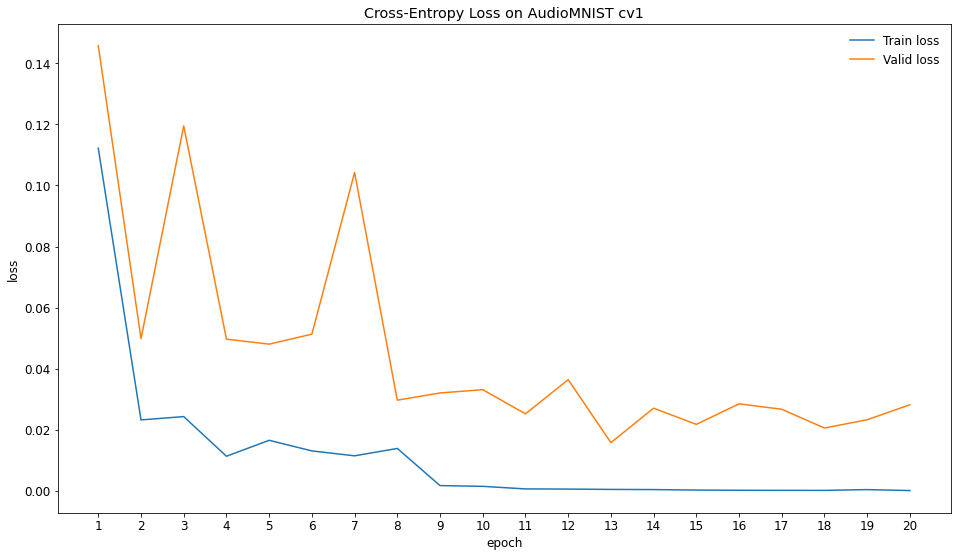

In [20]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(16, 9))

ax.plot(history['train']['epoch'], history['train']['loss'], color='tab:blue', label = 'Train loss')
ax.plot(history['valid']['epoch'], history['valid']['loss'], color='tab:orange', label = 'Valid loss')
ax.set_title('Cross-Entropy Loss on AudioMNIST cv1')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(loc = 0, frameon = False)
ax.set_xticks(history['train']['epoch'])

In [21]:
df2_ = {'train': pd.DataFrame(), 'validate': pd.DataFrame(), 'test': pd.DataFrame()}
for k in df_.keys():
    for j in range(len(files_[k]['cv3'])):
        df = pd.DataFrame({'file':files_[k]['cv3'][j]})
        df['audio'] = [librosa.load(df['file'][i], sr=16000) for i in range(len(df['file']))]
        df['label'] = [df['file'][i].rstrip(".wav").split("/")[-1].split("_")[0] for i in range(len(df['file']))]
        df2_[k] = df2_[k].append(df) 

In [22]:
train_data = AudioMNISTData(os.getcwd(), df2_['train'], 'file', 'label')
valid_data = AudioMNISTData(os.getcwd(), df2_['validate'], 'file', 'label')
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

100%|██████████████████████████████████████| 6000/6000 [00:32<00:00, 185.34it/s]


In [23]:
epochs = 5
history = train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

Epoch - 1 Train-Loss : 0.008611701443944084


 20%|█████████                                    | 1/5 [01:08<04:34, 68.63s/it]

Epoch - 1 Valid-Loss : 4.7961453426864866e-05 Valid-Accuracy : 1.0
Epoch - 2 Train-Loss : 0.003506532796443783


 40%|██████████████████                           | 2/5 [02:18<03:27, 69.32s/it]

Epoch - 2 Valid-Loss : 6.301368727660398e-05 Valid-Accuracy : 1.0
Epoch - 3 Train-Loss : 0.00304466519368902


 60%|███████████████████████████                  | 3/5 [03:27<02:18, 69.09s/it]

Epoch - 3 Valid-Loss : 6.681736161219003e-05 Valid-Accuracy : 1.0
Epoch - 4 Train-Loss : 0.002574759677447926


 80%|████████████████████████████████████         | 4/5 [04:36<01:08, 69.00s/it]

Epoch - 4 Valid-Loss : 5.567924763632467e-05 Valid-Accuracy : 1.0
Epoch - 5 Train-Loss : 0.0021993702381477203


100%|█████████████████████████████████████████████| 5/5 [05:45<00:00, 69.02s/it]

Epoch - 5 Valid-Loss : 7.881368013715929e-05 Valid-Accuracy : 1.0


In [24]:
filepath_pred = f"audio-mnist/6_FM_0.wav"
Audio(data=filepath_pred)

In [25]:
df_test = pd.DataFrame({'file': "audio-mnist/6_FM_0.wav", 'label': None}, index = [0])

In [48]:
test_data = AudioMNISTData(os.getcwd(), df_test, 'file', 'label')
test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 82.64it/s]


In [ ]:
audio_mnist = datasets.DatasetDict({"train":Dataset.from_dict(df_['train']),
                                    "valid":Dataset.from_dict(df_['validate']),
                                    "test":Dataset.from_dict(df_['test'])})
print(audio_mnist)

# Referencias

+ Becker, S., Ackermann, M., Lapuschkin, S., Müller, K. & Samek, W. (2018) [Interpreting and explaining deep neural networks for classification of audio signals](https://arxiv.org/abs/1807.03418). arXiv 2018. arXiv preprint arXiv:1807.03418.

+ Doshi, K. (2021) Audio deep learning made simple (part 1): State-of-the-art techniques, Medium. Towards Data Science. Disponible en: https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504 (Fecha de acceso: November 27, 2022). 

+ Ghosh, S. (2022) Keras Documentation: Audio Classification with hugging face transformers, Keras. Disponible en: https://keras.io/examples/audio/wav2vec2_audiocls/ (Fecha de acceso: November 27, 2022). 

+ He, K., Zhang, X., Ren, S., & Sun, J. (2016). [Deep residual learning for image recognition](https://arxiv.org/abs/1512.03385). In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

+ Montenegro, A., Montenegro, D., Pardo, C. & Jarma, O. (2022) Diplomado Avanzado en Inteligencia Arifical y Aprendizaje Profundo. Disponible en: https://github.com/AprendizajeProfundo/Diplomado-Avanzado

+ Panayotov, V., Chen, G., Povey, D. & Khudanpur, S. (2015) ["Librispeech: An ASR corpus based on public domain audio books,"](https://ieeexplore.ieee.org/document/7178964) 2015 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP), pp. 5206-5210, doi: 10.1109/ICASSP.2015.7178964.